# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 29.10.2021

Мягкий дедлайн: 23:59MSK 10.11.2021 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 13.11.2021

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.metrics import make_scorer

In [4]:
scaler = StandardScaler().fit(X_train, y_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
def pr_auc_score(y_true, y_pred):
    precision, recall, thr = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

# Создадим скор функции, чтобы использовать ее в подборе параметра
pr_auc_scorer = make_scorer(pr_auc_score, greater_is_better=True)

In [6]:
for i, c_ in enumerate(np.logspace(-6, 0, 10)):
    svc = LinearSVC(max_iter=100000, C=c_) #.fit(X_train, y_train)
    
    result = np.mean(cross_val_score(svc,
                                     X=X_train,
                                     y=y_train,
                                     cv=KFold(n_splits=5),
                                     scoring=pr_auc_scorer))
    
    print(f'{i}) C={c_:6f},        AUC-PR={result:6f}')

0) C=0.000001,        AUC-PR=0.808187
1) C=0.000005,        AUC-PR=0.811887
2) C=0.000022,        AUC-PR=0.820834
3) C=0.000100,        AUC-PR=0.829981
4) C=0.000464,        AUC-PR=0.831933
5) C=0.002154,        AUC-PR=0.833241
6) C=0.010000,        AUC-PR=0.833897
7) C=0.046416,        AUC-PR=0.833677
8) C=0.215443,        AUC-PR=0.833677
9) C=1.000000,        AUC-PR=0.833677


На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

In [7]:
### Обучим на стандартном C, так как он один из самых лучших
svc = LinearSVC(max_iter=100000).fit(X_train, y_train)

y_test_pred_svc = svc.decision_function(X_test)

#### Визуализация графиков

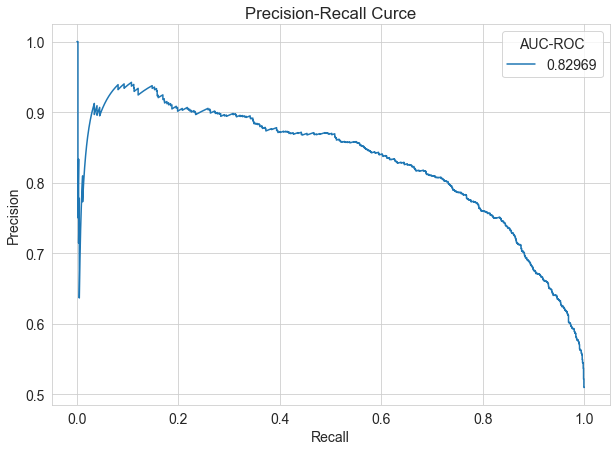

In [8]:
precision, recall, thr = precision_recall_curve(y_test, y_test_pred_svc)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, label=f'{pr_auc_score(y_test, y_test_pred_svc):.5f}')

# plt.ylim(0, 1)

plt.title('Precision-Recall Curce')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(title='AUC-ROC')

plt.show()

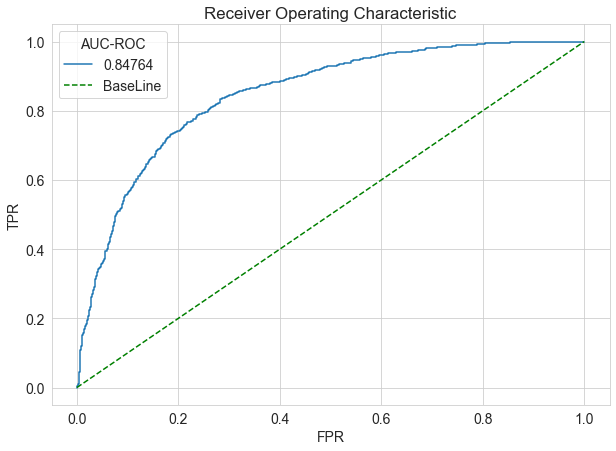

In [9]:
fpr, tpr, thr_roc = roc_curve(y_test, y_test_pred_svc)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'{roc_auc_score(y_test, y_test_pred_svc):.5f}')
plt.plot([0, 1], label='BaseLine', ls='--', c='g')

plt.title('Receiver Operating Characteristic')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend(title='AUC-ROC')

plt.show()

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
for i, c_ in enumerate(np.logspace(-6, 0, 10)):
    log_lr = LogisticRegression(max_iter=100000, C=c_) #.fit(X_train, y_train)
    
    result = np.mean(cross_val_score(log_lr,
                                     X=X_train,
                                     y=y_train,
                                     cv=KFold(n_splits=5),
                                     scoring=pr_auc_scorer))
    
    print(f'{i}) C={c_:6f},        AUC-PR={result:6f}')

0) C=0.000001,        AUC-PR=0.748048
1) C=0.000005,        AUC-PR=0.767183
2) C=0.000022,        AUC-PR=0.807377
3) C=0.000100,        AUC-PR=0.816872
4) C=0.000464,        AUC-PR=0.827216
5) C=0.002154,        AUC-PR=0.831298
6) C=0.010000,        AUC-PR=0.833259
7) C=0.046416,        AUC-PR=0.833989
8) C=0.215443,        AUC-PR=0.834107
9) C=1.000000,        AUC-PR=0.834107


In [12]:
log_lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)

y_test_pred_log_lr = log_lr.decision_function(X_test)

#### Визуализация графиков

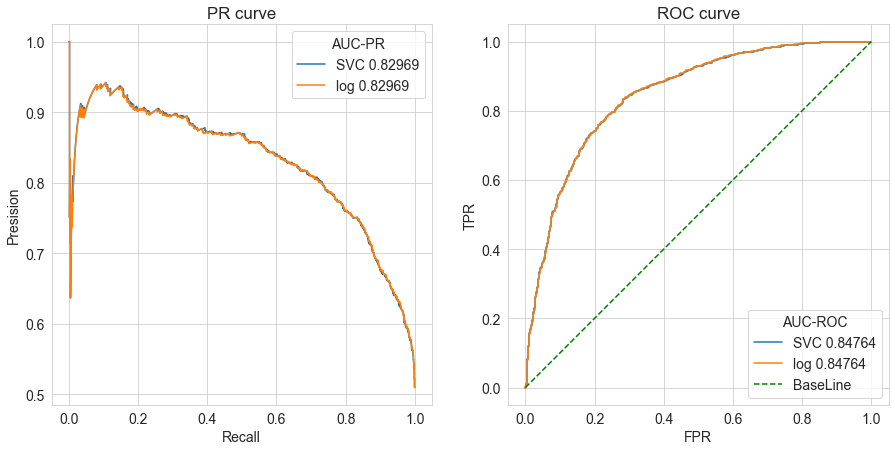

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# PR curve
precision, recall, thr = precision_recall_curve(y_test, y_test_pred_svc)
axs[0].plot(recall, precision, label=f'SVC {pr_auc_score(y_test, y_test_pred_svc):.5f}')

precision, recall, thr = precision_recall_curve(y_test, y_test_pred_log_lr)
axs[0].plot(recall, precision, label=f'log {pr_auc_score(y_test, y_test_pred_svc):.5f}')

axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Presision')
axs[0].set_title('PR curve')
axs[0].legend(title='AUC-PR')


# ROC curve
fpr, tpr, thr_roc = roc_curve(y_test, y_test_pred_svc)
axs[1].plot(fpr, tpr, label=f'SVC {roc_auc_score(y_test, y_test_pred_svc):.5f}')

fpr, tpr, thr_roc = roc_curve(y_test, y_test_pred_log_lr)
axs[1].plot(fpr, tpr, label=f'log {roc_auc_score(y_test, y_test_pred_svc):.5f}')

axs[1].plot([0, 1], label='BaseLine', ls='--', c='g')

axs[1].set_xlabel('FPR')
axs[1].set_ylabel('TPR')
axs[1].set_title('ROC curve')
axs[1].legend(title='AUC-ROC')

plt.show()

Различий нет.

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [14]:
from sklearn.svm import SVC

In [15]:
X, y = make_classification(
    n_samples=200, n_features=2, n_redundant=0, n_clusters_per_class=2,
    class_sep=3, random_state=42)

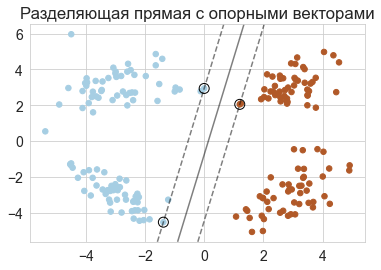

In [16]:
clf = SVC(kernel="linear", C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.title('Разделяющая прямая с опорными векторами')
plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

https://thedatafrog.com/en/articles/logistic-regression-neural-network/

https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html#sphx-glr-auto-examples-linear-model-plot-iris-logistic-py

C:\Users\bimas\AppData\Local\Temp/ipykernel_18612/2005040878.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)


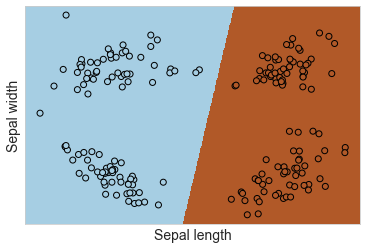

In [17]:
lr = LogisticRegression(max_iter=100000, C=1000)
lr.fit(X, y)

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.Paired)
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [18]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    
    plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.legend()
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

#### Подготовка данных

In [19]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

scaler = StandardScaler().fit(X_train, y_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Обучение моделей

In [20]:
svc = LinearSVC(max_iter=100000).fit(X_train, y_train)
lr = LogisticRegression(max_iter=100000).fit(X_train, y_train)

#### Визуализация 

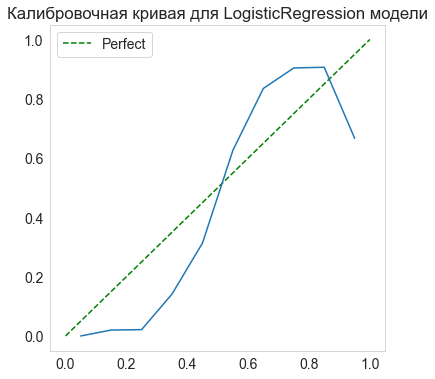

In [21]:
svc_pred = svc.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())

plot_calibration_curve(y_test, svc_pred)
plt.title('Калибровочная кривая для LogisticRegression модели')
plt.show()

SVM плохо предсказал вероятности (как и ожидалось), так что предсказания необходимо откалибровать.

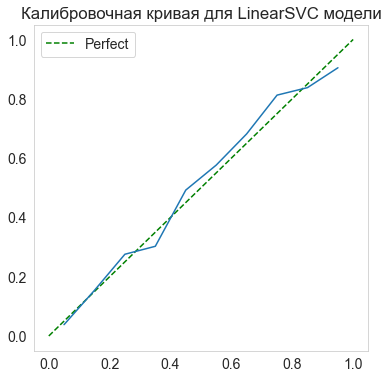

In [22]:
lr_pred = lr.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, lr_pred)
plt.title('Калибровочная кривая для LinearSVC модели')
plt.show()

Калибровочная кривая у логистической регрессии получилась очень близкой к идеальной.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [23]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [24]:
sigmoid_svc = CalibratedClassifierCV(svc, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_svc_pred))

SVC ROC-AUC: 0.8477515556442582


In [25]:
isotonic_svc = CalibratedClassifierCV(svc, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_svc_pred = isotonic_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, isotonic_svc_pred))

SVC ROC-AUC: 0.8475255266120849


In [26]:
sigmoid_lr = CalibratedClassifierCV(lr, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_lr_pred = sigmoid_lr.predict_proba(X_test)[:, 1]
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, sigmoid_lr_pred))

Logistic regression ROC-AUC: 0.8479262447487699


In [27]:
isotonic_lr = CalibratedClassifierCV(lr, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_lr_pred = isotonic_lr.predict_proba(X_test)[:, 1]
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, isotonic_lr_pred))

Logistic regression ROC-AUC: 0.8473937319060093


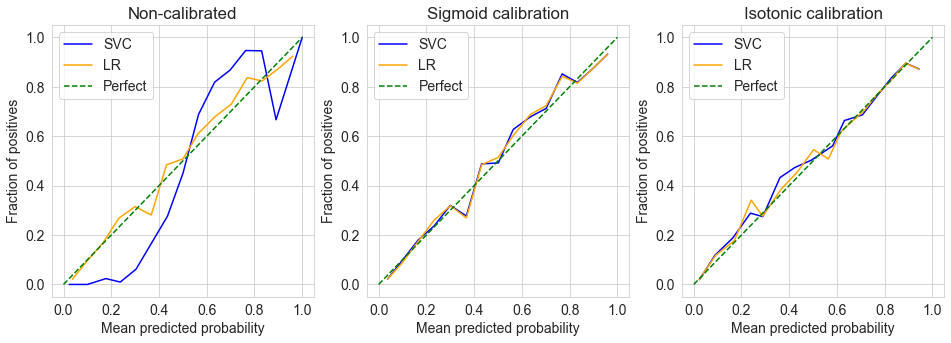

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, lr_pred, n_bins=15)

axs[0].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[0].plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
axs[0].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[0].set_title('Non-calibrated')

svc_true_prob, svc_pred_prob = calibration_curve(y_test, sigmoid_svc_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, sigmoid_lr_pred, n_bins=15)

axs[1].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[1].plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
axs[1].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[1].set_title('Sigmoid calibration')

svc_true_prob, svc_pred_prob = calibration_curve(y_test, isotonic_svc_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, isotonic_lr_pred, n_bins=15)

axs[2].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[2].plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
axs[2].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[2].set_title('Isotonic calibration')

for ax in axs:
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Fraction of positives')
    ax.legend()

plt.show()

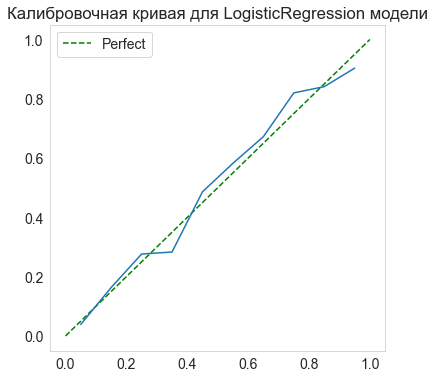

In [29]:
plot_calibration_curve(y_test, sigmoid_svc_pred)
plt.title('Калибровочная кривая для LogisticRegression модели')
plt.show()

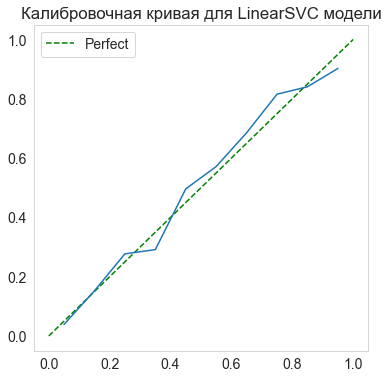

In [30]:
plot_calibration_curve(y_test, sigmoid_lr_pred)
plt.title('Калибровочная кривая для LinearSVC модели')
plt.show()

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [31]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# !unzip bank-additional.zip
df = pd.read_csv('input/04_bank-additional/bank-additional-full.csv', sep=';')

In [32]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [33]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'age':'nr.employed'],
                                                    df['y'],
                                                    test_size=0.25,
                                                    random_state=777,
                                                    stratify=df['y'])

Столбец `duration` не несёт информации для решения, так как мы не можем знать продолжительность звонка до того как совершить этот звонок. Кроме того, елси длительность звонка будет нулевой, то ответ сразу нет, поэтому этот столбец содержит информацию о целевой переменной напрямую, что плохо. Удалю этот столбец (это так же советуют делать в описании датасета на сайте).

In [34]:
X_train = X_train.drop('duration', axis=1)
X_test = X_test.drop('duration', axis=1)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: `AUC-ROC` чуствительна к балансу классов. А в нашей задаче как раз баланса нет, ниже я подсчитал, что всего 11.27% положительных ответов во всём датасете. То есть если сделать константную модель, которая будет всегда выдавать 'no', тогда мы получим хороший показатель `AUC-ROC`, в то время как `AUC-PR` позволяет избавиться от этой проблемы.

In [35]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [36]:
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                'contact', 'month', 'day_of_week', 'poutcome']
num_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [37]:
y_train = (y_train == 'yes')
y_test = (y_test == 'yes')

In [38]:
col_transformer = ColumnTransformer([
    ('OrdinalEncoder', OrdinalEncoder(), cat_features),
    ('StandardScaler', StandardScaler(), num_features)
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', col_transformer),
    ('LogisticRegression', LogisticRegression(max_iter=100000))
])

In [39]:
%%time
lr = lr_pipeline.fit(X_train, y_train)

Wall time: 239 ms


In [40]:
y_train_pred = lr.decision_function(X_train)
y_test_pred = lr.decision_function(X_test)

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.443283
Test AUC-PR score: 0.441875


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [41]:
col_transformer = ColumnTransformer([
    ('OneHotEncoder', OneHotEncoder(), cat_features),
    ('StandardScaler', StandardScaler(), num_features)
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', col_transformer),
    ('LogisticRegression', LogisticRegression(max_iter=100000))
])

In [42]:
%%time
lr = lr_pipeline.fit(X_train, y_train)

Wall time: 737 ms


In [43]:
y_train_pred = lr.decision_function(X_train)
y_test_pred = lr.decision_function(X_test)

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.459050
Test AUC-PR score: 0.449215


Качество выдаваемое моделью на тестовой выборке улучшилось, при использовании OneHotEncoder, но при этом на обучение ушло в три раза больше времени. Это связано с тем, что при использовании OneHotEncoder колличество признаков после кодирования сильно возрастает и обуение модели усложняется.

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [44]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encodings = {}
    
    def fit(self, X, y):
        X_ = X.copy()
        X_['target'] = y.copy()
        
        for column in X:
            self.encodings[column] = X_.groupby(by=column).mean()['target'].copy()
        return self
    
    def transform(self, X):
        return X.replace(self.encodings)

In [45]:
my_transformer = MeanTargetEncoding()
my_transformer.fit(X_train[cat_features], y_train)
X_trans = my_transformer.transform(X_train)

X_trans.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
23424,33,0.109551,0.101269,0.102727,0.128569,0.110367,0.113835,0.147733,0.107735,0.116111,7,999,0,0.088848,1.4,93.444,-36.1,4.964,5228.1
39990,32,0.067515,0.101269,0.102727,0.128569,0.115024,0.113835,0.051505,0.104400,0.116210,1,999,1,0.142140,-1.7,94.055,-39.8,0.761,4991.6
9340,27,0.315133,0.139834,0.104057,0.051851,0.110367,0.113835,0.051505,0.104400,0.110226,1,999,0,0.088848,1.4,94.465,-41.8,4.967,5228.1
5365,34,0.067515,0.101269,0.081501,0.128569,0.115024,0.113835,0.051505,0.063396,0.110226,1,999,0,0.088848,1.1,93.994,-36.4,4.857,5191.0
2797,41,0.109059,0.101269,0.081501,0.128569,0.110367,0.113835,0.051505,0.063396,0.116111,1,999,0,0.088848,1.1,93.994,-36.4,4.859,5191.0


In [46]:
col_transformer = ColumnTransformer([
    ('MeanTargetEncoding', MeanTargetEncoding(), cat_features),
    ('StandardScaler', StandardScaler(), num_features)
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', col_transformer),
    ('LogisticRegression', LogisticRegression(max_iter=100000))
])

**Мое замечание:** После mean-target encoding, есть смысл применять StandardScaler, так как переменные будут вещественными и могут принимать разный размер. Стоит проверить эту идею, если вдруг буду этим заниматься.

In [47]:
%%time
lr = lr_pipeline.fit(X_train, y_train)

Wall time: 403 ms


In [48]:
y_train_pred = lr.decision_function(X_train)
y_test_pred = lr.decision_function(X_test)

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.438485
Test AUC-PR score: 0.442335


Несмотря на то, что mean-target encoding реализован самостоятельно (не факт, что наиболее эффективным способом), на кодирование признаков и обучение модели ушло в два раза меньше времени, чем на то же самое с использованием OneHotEncoder. Хотя с OrdinalEncoder всё отработало быстрее, возможно с более эффективной реализацией алгоритма, время могло быть практически равным.

Результат на тестовой выборке при использовании mean-target encoding получился примерно таким же как при использовании OrdinalEncoder и уступает результату с OneHotEncoder.

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [49]:
class MeanTargetEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, noise=0):
        self.noise = noise
        self.encodings = {}
    
    def fit(self, X, y):
        X_ = X.copy()
        X_['target'] = y.copy()
        
        for column in X:
            self.encodings[column] = X_.groupby(by=column).mean()['target'].copy()
            # Добавление шума - Вариант 1
            self.encodings[column] += np.random.normal(scale=self.noise, size=self.encodings[column].shape[0])
        return self
    
    def transform(self, X):
        return X.replace(self.encodings)

**Моя идея шума** - Если добавить шум после применения трансформации, тогда у нас не будет повторяющихся объектов, что сделает эти признкаи не категориальными. Считаю, что этот подход неправильным.

In [50]:
col_transformer = ColumnTransformer([
    ('MeanTargetEncoding', MeanTargetEncoding(1), cat_features),
    ('StandardScaler', StandardScaler(), num_features)
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', col_transformer),
#     ('StandardScaler', StandardScaler(), num_features),
    ('LogisticRegression', LogisticRegression(max_iter=100000))
])

In [51]:
%%time
lr = lr_pipeline.fit(X_train, y_train)

Wall time: 279 ms


In [52]:
y_train_pred = lr.decision_function(X_train)
y_test_pred = lr.decision_function(X_test)

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.439644
Test AUC-PR score: 0.437762


### Подбор шума

In [53]:
for noise in np.logspace(-1, 1, 20):
    col_transformer = ColumnTransformer([
        ('MeanTargetEncoding', MeanTargetEncoding(noise), cat_features),
        ('StandardScaler', StandardScaler(), num_features)
    ])

    lr_pipeline = Pipeline([
        ('ColumnTransformer', col_transformer),
    #     ('StandardScaler', StandardScaler(), num_features),
        ('LogisticRegression', LogisticRegression(max_iter=100000))
    ])
    
    lr = lr_pipeline.fit(X_train, y_train)
    
    y_train_pred = lr.decision_function(X_train)
    y_test_pred = lr.decision_function(X_test)
    
    print(f'noise = {noise}')
    print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
    print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')
    abs_score = np.abs(pr_auc_score(y_train, y_train_pred) - pr_auc_score(y_test, y_test_pred))
    print(f'abs_score = {abs_score}\n')

noise = 0.1
Train AUC-PR score: 0.436206
Test AUC-PR score: 0.436417
abs_score = 0.00021140414936804408

noise = 0.12742749857031338
Train AUC-PR score: 0.430072
Test AUC-PR score: 0.443381
abs_score = 0.01330909296893562

noise = 0.16237767391887217
Train AUC-PR score: 0.433822
Test AUC-PR score: 0.432007
abs_score = 0.001814930331268505

noise = 0.20691380811147897
Train AUC-PR score: 0.439387
Test AUC-PR score: 0.440721
abs_score = 0.0013340185840702845

noise = 0.26366508987303583
Train AUC-PR score: 0.440754
Test AUC-PR score: 0.438918
abs_score = 0.0018359333232276787

noise = 0.33598182862837817
Train AUC-PR score: 0.440739
Test AUC-PR score: 0.435799
abs_score = 0.004940238033657229

noise = 0.42813323987193935
Train AUC-PR score: 0.444418
Test AUC-PR score: 0.435213
abs_score = 0.009205126042051093

noise = 0.5455594781168519
Train AUC-PR score: 0.434711
Test AUC-PR score: 0.440268
abs_score = 0.005556976725408114

noise = 0.6951927961775606
Train AUC-PR score: 0.437108
Test A

**Вывод:** Практически нет никаких изменений, это связано с тем, что признаки изначально имели малую значимость. Поэтому тяжело подобрать оптимальные параметры относительно регулированяи уровян шума.

Выбрать хороший шум можно балансирую между качеством и уровнем переобучения. Наблюдаем, что с ростом шума переобучение становится ниже, так как значимость признака становится низкой.

__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [54]:
#your code here

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [55]:
class MeanTargetEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, noise=0, C=10):
        self.noise = noise
        self.encodings = {}
        self.C = C
    
    def smoothing(self, x):  # Сглаживание
        positive_count = x.sum() + self.C * self.global_mean
        count = x.shape[0] + self.C
        return positive_count / count
    
    def fit(self, X, y):
        self.global_mean = y.mean()
        X_ = X.copy()
        X_['target'] = y.copy()
        
        for column in X:
            # Использование сглаживания - Вариант 1
#             numerator = X_.groupby(by=column).sum()['target'] + self.C * y.mean()
#             denominator = X_.groupby(by=column).size() + self.C
#             self.encodings[column] = numerator / denominator
            
            # Использование сглаживания - Вариант 2
            self.encodings[column] = X_['target'].groupby(X_[column]).agg([self.smoothing])['smoothing']
            # Добавление шума - Вариант 1
            self.encodings[column] += np.random.normal(scale=self.noise, size=self.encodings[column].shape[0])
        return self
    
    def transform(self, X):
        return X.replace(self.encodings)

In [56]:
col_transformer = ColumnTransformer([
    ('MeanTargetEncoding', MeanTargetEncoding(), cat_features),
    ('StandardScaler', StandardScaler(), num_features)
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', col_transformer),
    ('LogisticRegression', LogisticRegression(max_iter=100000))
])

In [57]:
%%time
lr = lr_pipeline.fit(X_train, y_train)

Wall time: 376 ms


In [58]:
y_train_pred = lr.decision_function(X_train)
y_test_pred = lr.decision_function(X_test)

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.438479
Test AUC-PR score: 0.442399


Результаты без использования сглаживани и шума:

Train AUC-PR score: 0.438485

Test AUC-PR score: 0.442335

Результаты при использовани сглаживани и без шума:

Train AUC-PR score: 0.438479

Test AUC-PR score: 0.442399

__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [59]:
len(X_train['age'].unique())

76

Всегод 76 уничальных значений возраста.

In [60]:
age_train_unique = set(X_train['age'].unique())
age_test_unique = set(X_test['age'].unique())
age_test_unique.difference(age_train_unique)
X_test[X_test['age'].isin([87, 98])]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
38452,98,retired,married,basic.4y,unknown,yes,no,cellular,oct,fri,1,2,2,success,-3.4,92.431,-26.9,0.730,5017.5
38455,98,retired,married,basic.4y,unknown,yes,no,cellular,oct,fri,2,999,0,nonexistent,-3.4,92.431,-26.9,0.730,5017.5
37743,87,retired,divorced,basic.4y,no,no,no,cellular,aug,fri,1,999,0,nonexistent,-2.9,92.201,-31.4,0.849,5076.2


Таких уникальных в тесте значений всего трое, поэтому можно их безболезненно удалить, чтобы не усложнять слишком сильно трансформер. (Тем более, что не совсмем понятно, как это можно было бы доработать, так как в ohe, например, неизвестные на трейне значений просто игнорируются при обработке теста, а тут игнорировать не получится, нужно присваивать таким элементам тоже какое-то значение, а вот какое, непонятно).

In [61]:
mask = (~X_test['age'].isin([87, 98]))
X_test = X_test.loc[mask]
y_test = y_test.loc[mask]

In [62]:
cat_features_new = cat_features + ['age']
num_features_new = num_features.copy()
num_features_new.remove('age')

In [63]:
col_transformer = ColumnTransformer([
    ('MeanTargetEncoding', MeanTargetEncoding(), cat_features_new),
    ('StandardScaler', StandardScaler(), num_features_new)
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', col_transformer),
    ('LogisticRegression', LogisticRegression(max_iter=100000))
])

In [64]:
%%time
lr = lr_pipeline.fit(X_train, y_train)

Wall time: 391 ms


In [65]:
y_train_pred = lr.decision_function(X_train)
y_test_pred = lr.decision_function(X_test)

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.441338
Test AUC-PR score: 0.435869


Кодирование `age` MeanTargetEncoding

Train AUC-PR score: 0.441338

Test AUC-PR score: 0.440495

Без использование MeanTargetEncoding:

Train AUC-PR score: 0.438479

Test AUC-PR score: 0.442399

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

#### Кодирование

In [66]:
day_code = {'mon' : 0, 'tue' : 1, 'wed' : 2, 'thu' : 3, 'fri' : 4}
month_code = {'mar' : 0, 'apr' : 1, 'may' : 2, 'jun' : 3, 'jul' : 5, 'aug' : 6,
              'sep' : 7, 'oct' : 8, 'nov' : 9, 'dec' : 10}

In [67]:
X_train['month'] = X_train['month'].map(month_code)
X_train['day_of_week'] = X_train['day_of_week'].map(day_code)

In [68]:
X_test['month'] = X_test['month'].map(month_code)
X_test['day_of_week'] = X_test['day_of_week'].map(day_code)

#### Новые колонки

In [69]:
num_features_new += ['month', 'day_of_week']
cat_features_new.remove('month')
cat_features_new.remove('day_of_week')

#### Обучение

In [70]:
col_transformer = ColumnTransformer([
    ('MeanTargetEncoding', MeanTargetEncoding(), cat_features_new),
    ('StandardScaler', StandardScaler(), num_features_new)
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', col_transformer),
    ('LogisticRegression', LogisticRegression(max_iter=100000))
])

lr = lr_pipeline.fit(X_train, y_train)

y_train_pred = lr.decision_function(X_train)
y_test_pred = lr.decision_function(X_test)

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.442868
Test AUC-PR score: 0.430015


Кодирование `month`, `day_of_week` числом:

Train AUC-PR score: 0.442868

Test AUC-PR score: 0.434569

Кодирование `month`, `day_of_week` MeanTargetEncoding:

Train AUC-PR score: 0.441338

Test AUC-PR score: 0.440495

Наблюдаем после кодирования `month`, `day_of_week` числом небольшой эффект переобучения.

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ явный плюс использования счётчиков по сравнению с ohe - это более быстрое кодирование признаков и обучение модели, так как счётчики, в отличие от ohe не порождают такое количество новых признаков. Но, тем не менее, ohe показывает лучший результат, чем счётчики. Возможно, что при использовании другой модели, вместо линейной регессии результат был бы другим, но тем не менее, имеем, что имеем.

Так же, можно заметить, что использование ohe, например при обучении деревьев было бы крайне плохой идеей, так как дереья будут очень долго обучаться на выборке с большим количеством признаков, порождённым ohe. Но ещё большей проблемой моежт стать то, что деревья очень любят переобучаться, поэтому для этого семейства моделей ohe имеет гораздо больше минусов по сравнению с счётчиками.

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [71]:
df = pd.read_csv('input/04_bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [72]:
cat_features = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
    'month', 'day_of_week', 'poutcome'
]
num_features = [
    'age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
    'cons.conf.idx', 'euribor3m', 'nr.employed'
]

In [73]:
X_train_hot = X_train.drop(cat_features, axis=1)
X_test_hot = X_test.drop(cat_features, axis=1)

In [74]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(X_train[cat_features])
names = ohe.get_feature_names_out()
X_train_hot = pd.concat(
    [X_train_hot, pd.DataFrame(ohe.transform(X_train[cat_features]),
                               index=X_train.index,
                               columns=names)],
    axis=1)
X_test_hot = pd.concat(
    [X_test_hot, pd.DataFrame(ohe.transform(X_test[cat_features]),
                              index=X_test.index,
                              columns=names)],
    axis=1)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [75]:
lr = LogisticRegression(max_iter=100000).fit(X_train_hot, y_train)

y_train_pred = lr.decision_function(X_train_hot)
y_test_pred = lr.decision_function(X_test_hot)

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.445264
Test AUC-PR score: 0.441870


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [76]:
# Выбор признаков с наибольшим вкладом
best_number_columns = np.argsort(-np.abs(lr.coef_[0]))[:40]

In [77]:
X_train_best = X_train_hot.iloc[:, best_number_columns]
X_test_best = X_test_hot.iloc[:, best_number_columns]

In [78]:
X_train_hot.shape

(32950, 62)

In [79]:
lr = LogisticRegression(max_iter=100000).fit(X_train_best, y_train)

y_train_pred = lr.decision_function(X_train_best)
y_test_pred = lr.decision_function(X_test_best)

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.441740
Test AUC-PR score: 0.445259


Не наблюдам большого влияния, причиной служит то, что у нас не настолько большая разница масштабов между признаками. Но в любом случае, этот подход не правильный!

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [80]:
col_transformer = ColumnTransformer([
    ('StandardScaler', StandardScaler(), num_features)],
    remainder='passthrough')

lr_pipeline = Pipeline([
    ('ColumnTransformer', col_transformer),
    ('LogisticRegression', LogisticRegression(max_iter=100000))
])

In [81]:
lr = lr_pipeline.fit(X_train_hot, y_train)

y_train_pred = lr.decision_function(X_train_hot)
y_test_pred = lr.decision_function(X_test_hot)

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.458609
Test AUC-PR score: 0.447419


StandardScaler увеличил качество. Поэтому оценить вклад станет сложнее. При этом, отбор топ 40 признаков не оказал большого влияния, что ещё усложняет оценку.

In [82]:
lr_coef = lr_pipeline.get_params()['steps'][-1][-1].coef_[0]

In [83]:
# Выбор признаков с наибольшим вкладом
best_number_columnss = np.argsort(-np.abs(lr_coef))[:40]

In [84]:
X_train_best = X_train_hot.iloc[:, best_number_columns]
X_test_best = X_test_hot.iloc[:, best_number_columns]

In [85]:
lr = LogisticRegression(max_iter=100000).fit(X_train_best, y_train)

y_train_pred = lr.decision_function(X_train_best)
y_test_pred = lr.decision_function(X_test_best)

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.441740
Test AUC-PR score: 0.445259


Не наблюдаем большого влияния, можно сдлетать выводы о том, что мы отбросили малозначимые признаки. Скорее всего, при должной настройки и подборе гиперпараметров мы бы получили лучший уровень обобщающей способности. Либо использование другой модели могло привести вообще к другому результату. 

На удивление, мы получили практически аналогичный результат первому отборе топ 40 признаков. Думаю, это связано с масштабами, он не слишком сильно отличается.

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [86]:
print(len(ohe.get_feature_names_out()) + len(num_features))
print(X_train_hot.shape[1])

62
62


In [87]:
col_transformer = ColumnTransformer([
    ('StandardScaler', StandardScaler(), X_train_hot.columns)],
    remainder='passthrough')

lr_pipeline = Pipeline([
    ('ColumnTransformer', col_transformer),
    ('LogisticRegression', LogisticRegression(max_iter=100000))
])

In [88]:
lr = lr_pipeline.fit(X_train_hot, y_train)

y_train_pred = lr.decision_function(X_train_hot)
y_test_pred = lr.decision_function(X_test_hot)

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.458689
Test AUC-PR score: 0.447260


На качество данный трюк не оказывает особо воздейсвия, что логично. Попробуем выплнить отбор топ 40 признаков.

In [89]:
lr_coef = lr_pipeline.get_params()['steps'][-1][-1].coef_[0]

In [90]:
# Выбор признаков с наибольшим вкладом
best_number_columnss = np.argsort(-np.abs(lr_coef))[:40]

In [91]:
X_train_best = X_train_hot.iloc[:, best_number_columns]
X_test_best = X_test_hot.iloc[:, best_number_columns]

In [92]:
lr = LogisticRegression(max_iter=100000).fit(X_train_best, y_train)

y_train_pred = lr.decision_function(X_train_best)
y_test_pred = lr.decision_function(X_test_best)

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.441740
Test AUC-PR score: 0.445259


Ничего не изменилось, так собственно и должно быть)

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



**Скалирование признаков** Воспользуемся данным способом, это позволит выполнять отбор признаков. Так как после применения ColumnTransformer возникают сложности с наименованием столбцов.

In [93]:
# lr.steps[0][1].named_transformers_['OneHotEncoder'].get_feature_names_out()

In [94]:
col_transformer = ColumnTransformer([
    ('StandardScaler', StandardScaler(), num_features)],
    remainder='passthrough')

lr_pipeline = Pipeline([
    ('ColumnTransformer', col_transformer),
    ('LogisticRegression', LogisticRegression(max_iter=100000, C=1.0))
])

lr = lr_pipeline.fit(X_train_hot, y_train)

y_train_pred = lr.decision_function(X_train_hot)
y_test_pred = lr.decision_function(X_test_hot)

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.458609
Test AUC-PR score: 0.447419


In [95]:
def t_stat_count(feature, y):
    y_mask = (y > 0)
    
    n_plus = y_mask.sum()
    n_neg = y.shape - n_plus
    mu_plus = np.mean(feature[y_mask])
    mu_neg = np.mean(feature[~y_mask])
    std_plus = np.std(feature[y_mask])
    std_neg = np.std(feature[~y_mask])
    
    return np.abs(mu_plus - mu_neg) / np.sqrt((n_plus * std_plus**2 + n_neg * std_neg**2) / (n_plus + n_neg))

In [96]:
%%time
t_statistic = {}
for col_name in X_train_hot.columns:
    t_statistic[col_name] = t_stat_count(X_train_hot[col_name], y_train)

sorted_keys = sorted(t_statistic, key=t_statistic.get, reverse=True)

Wall time: 121 ms


In [97]:
X_train_best = X_train_hot[sorted_keys[:40]]
X_test_best = X_test_hot[sorted_keys[:40]]

In [98]:
col_transformer = ColumnTransformer([
    ('StandardScaler', StandardScaler(), num_features)],
    remainder='passthrough')

lr_pipeline = Pipeline([
    ('ColumnTransformer', col_transformer),
    ('LogisticRegression', LogisticRegression(max_iter=100000))
])

lr = lr_pipeline.fit(X_train_best, y_train)

y_train_pred = lr.decision_function(X_train_best)
y_test_pred = lr.decision_function(X_test_best)

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.454199
Test AUC-PR score: 0.451194


Качество после отбора стало выше по сравнению с прошлыми методами. Делаем выводы о том, что Методы фильтрации способны отбирать более значимые признаки.

### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

**Преобразование данных**

In [99]:
col_transformer = ColumnTransformer([
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_features),
    ('StandardScaler', StandardScaler(), num_features)],
    remainder='passthrough')

X_train_CT = col_transformer.fit_transform(X_train)
X_test_CT = col_transformer.transform(X_test)

**Получаем колноки после преобразования**

In [100]:
columns_onehot = col_transformer.named_transformers_['OneHotEncoder'].get_feature_names_out()
columns_scaler = col_transformer.named_transformers_['StandardScaler'].get_feature_names_out()

In [101]:
all_columns = np.append(columns_onehot,  columns_scaler)

**Приведение данных после преобразования к DataFrame**

In [102]:
X_train_CT = pd.DataFrame(X_train_CT, columns=all_columns)
X_test_CT = pd.DataFrame(X_test_CT, columns=all_columns)

**Подготовка данных к отбору признаков**

In [103]:
X_train_wrapper, X_valid, y_train_wrapper, y_valid = train_test_split(X_train_CT, 
                                                                      y_train, 
                                                                      test_size=0.5, 
                                                                      random_state=777, 
                                                                      stratify=y_train)

**Отбор признаков**

In [104]:
lr = LogisticRegression(max_iter=100000).fit(X_train_wrapper, y_train_wrapper)

y_train_pred = lr.decision_function(X_train_wrapper)
y_valid_pred = lr.decision_function(X_valid)

print(f'Train AUC-PR score: {pr_auc_score(y_train_wrapper, y_train_pred):6f}')
print(f'Valid AUC-PR score: {pr_auc_score(y_valid, y_valid_pred):6f}')

# Сохраним качетсво без удаления признаков
base_valid_score = pr_auc_score(y_valid, y_valid_pred)

Train AUC-PR score: 0.463541
Valid AUC-PR score: 0.445463


In [105]:
%%time

columns_score = {}

for column in all_columns:
    # Удаление признака
    X_train_fit = X_train_wrapper.drop([column], axis=1)
    X_valid_fit = X_valid.drop([column], axis=1)
    
    # Обучение модели
    lr = LogisticRegression(max_iter=100000).fit(X_train_fit, y_train_wrapper)
    
    # Сохранение результатов
    y_valid_pred = lr.decision_function(X_valid_fit)
    new_valid_score = pr_auc_score(y_valid, y_valid_pred)
    
    columns_score[column] = new_valid_score - base_valid_score

Wall time: 16.5 s


In [106]:
sorted_columns = sorted(columns_score, key=columns_score.get, reverse=False)

In [107]:
print(columns_score['cons.price.idx'])
print(columns_score['previous'])

-0.006682995318618101
0.0013402452890699523


При удалении `cons.price.idx`, качество упало, а при удалении `previous` качество стало выше. Можно ещё было смотреть изменение по модулю и выбирать столбцы с наибольшим влиянием.

**Обучим модель без использования отобранных признаков**

In [108]:
lr = LogisticRegression(max_iter=100000).fit(X_train_CT, y_train)

y_train_pred = lr.decision_function(X_train_CT)
y_test_pred = lr.decision_function(X_test_CT)

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.458623
Test AUC-PR score: 0.447272


**Обучим модель на отобранных признаках**

In [109]:
lr = LogisticRegression(max_iter=100000).fit(X_train_CT[sorted_columns[:40]], y_train)

y_train_pred = lr.decision_function(X_train_CT[sorted_columns[:40]])
y_test_pred = lr.decision_function(X_test_CT[sorted_columns[:40]])

print(f'Train AUC-PR score: {pr_auc_score(y_train, y_train_pred):6f}')
print(f'Test AUC-PR score: {pr_auc_score(y_test, y_test_pred):6f}')

Train AUC-PR score: 0.446892
Test AUC-PR score: 0.450311


**Вывод:** Методы фильтрации дают результат немного лучше и требует меньше времени на обучение. Проблема текущего метода-обёртки заключается в том, что он не учитывает взаимодействие признаков.

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [110]:
# set('one two'.split()) == set('two one'.split())

In [111]:
# %%time
# def get_score(fit_columns):
#     lr = LogisticRegression(max_iter=100000).fit(X_train_wrapper[fit_columns], y_train_wrapper)
#     y_valid_pred = lr.decision_function(X_valid[fit_columns])
#     return pr_auc_score(y_valid, y_valid_pred)


# # Комбинации всех скоров - можем считать это технологией cash
# # combination_score = {}

# # Лучшие комбинации признаков
# best_combination = {}

# for column in all_columns:
#     fit_columns = [column]
#     start_score = get_score(fit_columns)

#     other_columns = np.setdiff1d(all_columns, [column])  # Остальные столбцы, которые необходимо обойти

#     while len(other_columns):
#         columns_score = {}

#         for add_column in other_columns:
#             score = start_score - get_score(fit_columns + [add_column])
#             columns_score[add_column] = score

#         sorted_columns = sorted(columns_score, key=columns_score.get, reverse=True)
#         if columns_score.get(sorted_columns[0]) < 0:
#             break
#         fit_columns.append(sorted_columns[0])  # Добавляем столбец с лучшим вкладом
#         other_columns = np.setdiff1d(other_columns, [sorted_columns[0]])  # Удаляем столбец из обхода

#     best_combination[get_score(fit_columns)] = fit_columns

Реализация выше выполняет полный перебор, что достаточно долго. Просто тест)

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** В данной моделе t-статистика была лучшей, и заняла очень мало времени.

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [112]:
df = pd.read_csv('input/04_bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [113]:
def cross_validated_profit(X, rand_low=10, rand_high=11, C=1.0):
    cross_validation = KFold(n_splits=5, shuffle=True, random_state=500)

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('scaling', StandardScaler(), num_features),
    ])
    pipeline = Pipeline(steps=[
        ('enc_and_scaling', column_transformer),
        ('classifier', LogisticRegression(max_iter=100000, C=C))
    ])

    profits = []
    for train_index, test_index in cross_validation.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = pipeline.fit(X_train, y_train)
        result = model.predict(X_test)

        dollar_10 = sum(y_test[result]) * np.random.randint(rand_low, rand_high)
        dollar_1 = sum(result)

        profits.append(dollar_10 - dollar_1)

    return np.mean(profits), np.std(profits)

In [114]:
mean, std = cross_validated_profit(X)

print('Mean profit:', mean)
print('Std profit:', std)

Mean profit: 1805.8
Std profit: 108.67640038205167


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [115]:
mean, std = cross_validated_profit(X, rand_low=0, rand_high=20)

print('Mean profit:', mean)
print('Std profit:', std)

Mean profit: 939.0
Std profit: 1080.0729604985027


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [116]:
c_space = np.linspace(0.01, 10, 10)

profits = []
errors = []
for c_value in c_space:
    mean, std = cross_validated_profit(X, rand_low=0, rand_high=20, C=c_value)

    profits.append(mean)
    errors.append(std)

best_profit = max(profits)
best_c = c_space[profits.index(best_profit)]
best_error = errors[profits.index(best_profit)]

print('Maximal profit:', best_profit)
print('Best C for profit:', best_c)
print('Std on that C:', best_error)

Maximal profit: 2918.6
Best C for profit: 7.78
Std on that C: 1116.352023333142


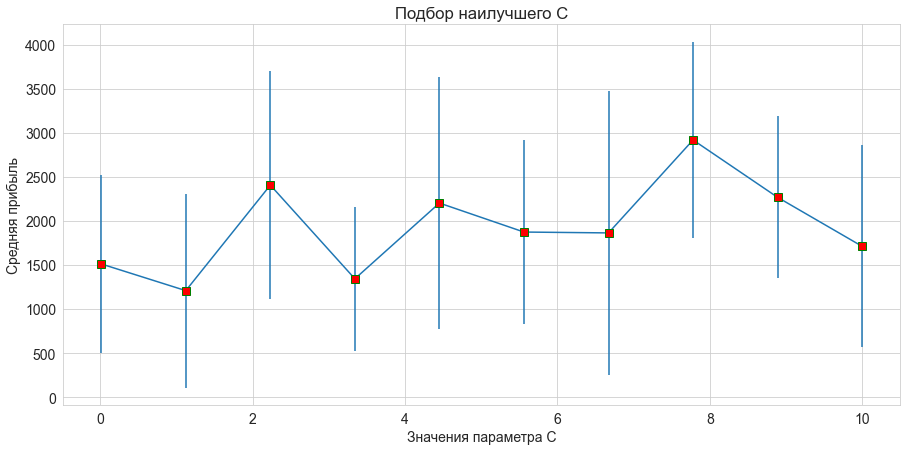

In [117]:
plt.figure(figsize=(15, 7))
plt.errorbar(c_space, profits, errors, marker='s', mfc='red', mec='green', ms=8, mew=1)

plt.xlabel('Значения параметра C')
plt.ylabel('Средняя прибыль')
plt.title('Подбор наилучшего C')
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [118]:
n = 10

best_profits = []
best_cs = []
for i in range(n):
    c_space = np.linspace(0.01, 10, 10)

    profits = []
    errors = []
    for c_value in c_space:
        mean, std = cross_validated_profit(X, rand_low=0, rand_high=20, C=c_value)

        profits.append(mean)
        errors.append(std)

    best_profit = max(profits)
    best_c = c_space[profits.index(best_profit)]

    best_profits.append(best_profit)
    best_cs.append(best_c)

In [119]:
maxbest_profit = max(best_profits)
maxbest_c = best_cs[best_profits.index(maxbest_profit)]

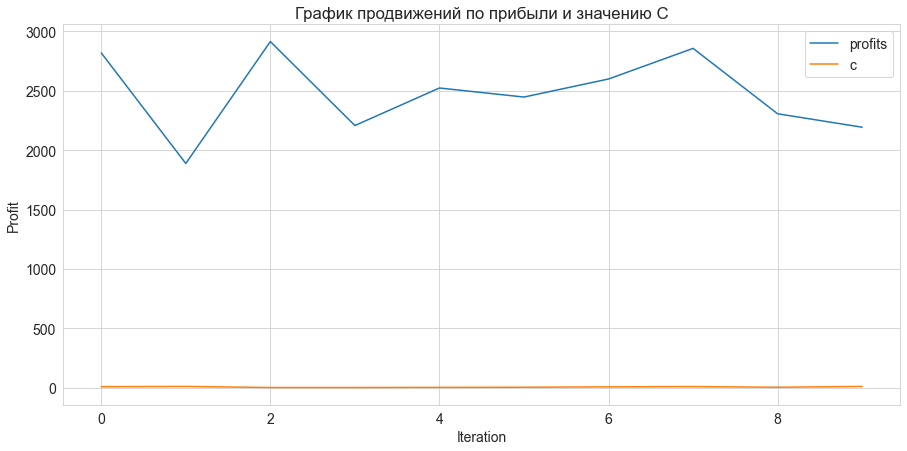

In [120]:
plt.figure(figsize=(15, 7))
x_space = np.arange(10)

plt.plot(x_space, best_profits, label='profits')
plt.plot(x_space, best_cs, label='c')

plt.title('График продвижений по прибыли и значению C')

plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Profit')
plt.show()

Закономерности нет.

In [121]:
best_cs

[7.78, 10.0, 1.12, 1.12, 2.23, 3.34, 6.67, 8.89, 3.34, 10.0]

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Мы бы предпочли precision, если бы потери при неправильно предсказанном клиенте (true-negative) были высокие. Но нет, в таком случае мы просто отдадим  работнику и потери будут незначительные. Но при этом нам не хочется пропускать людей, готовых взять кредит (false-positive), поэтому предпочтительнее использовать recall.

Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [123]:
from sklearn.metrics import precision_score, recall_score

In [124]:
cross_validation = KFold(n_splits=5, shuffle=True, random_state=500)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('scaling', StandardScaler(), num_features),
])
pipeline = Pipeline(steps=[
    ('enc_and_scaling', column_transformer),
    ('classifier', LogisticRegression(max_iter=100000, C=maxbest_c))
])

folds_profits, folds_recalls, folds_precision = {}, {}, {}

for train_index, test_index in cross_validation.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = pipeline.fit(X_train, y_train)

    for threshold in np.arange(0, 1.01, 0.01):
        result = model.predict_proba(X_test)[:, 1] > threshold

        dollar_10 = sum(y_test[result]) * np.random.randint(0, 20)
        dollar_1 = sum(result)

        folds_profits[threshold] = folds_profits.get(threshold, []) + [dollar_10 - dollar_1]
        folds_recalls[threshold] = folds_recalls.get(threshold, []) + [recall_score(y_test, result, zero_division=0)]
        folds_precision[threshold] = folds_precision.get(threshold, []) + [precision_score(y_test, result, zero_division=1)]
            
mean_profit, mean_recall, mean_precision = {}, {}, {}  

for threshold in folds_profits:
    mean_profit[threshold] = np.mean(folds_profits[threshold])
    mean_recall[threshold] = np.mean(folds_recalls[threshold])
    mean_precision[threshold] = np.mean(folds_precision[threshold])

In [125]:
best_threshold = sorted(mean_profit.items(), key=lambda x: x[1])[-1][0]

best_threshold

0.07

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

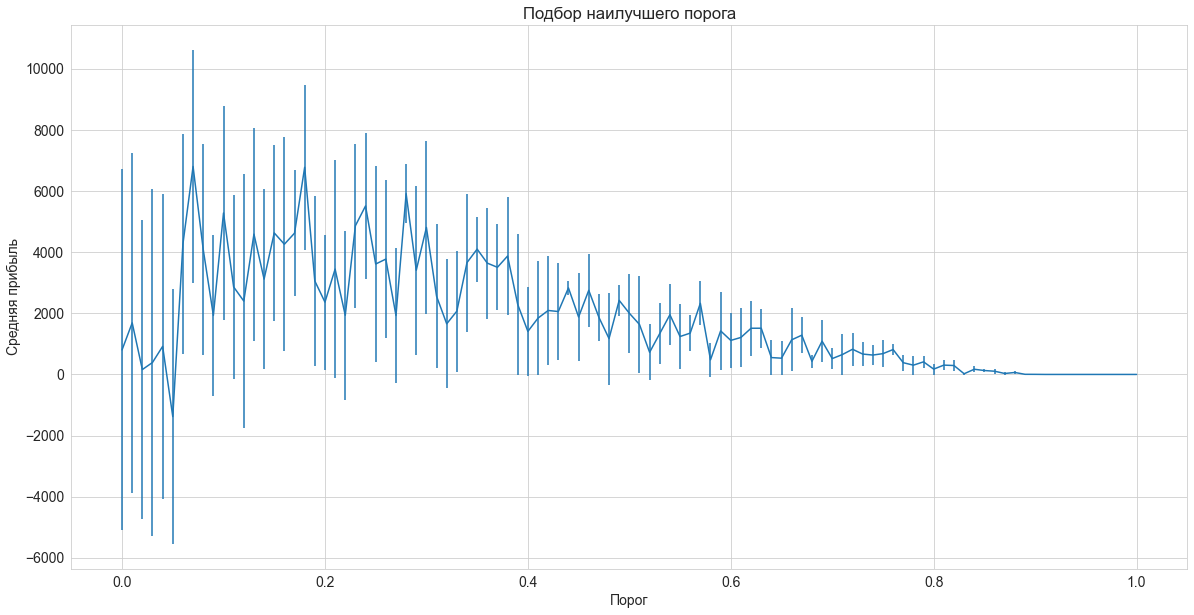

In [126]:
plt.figure(figsize=(20, 10))
errors_per_fold = [np.std(value) for key, value in folds_profits.items()]

plt.errorbar(mean_profit.keys(), mean_profit.values(), errors_per_fold, mfc='red', mec='green', ms=20, mew=4)

plt.xlabel('Порог')
plt.ylabel('Средняя прибыль')
plt.title('Подбор наилучшего порога')
plt.show()

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [127]:
precisions = []
recalls = []
for train_index, test_index in cross_validation.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = pipeline.fit(X_train, y_train)

    result = model.predict_proba(X_test)[:, 1] > best_threshold

    precisions.append(precision_score(y_test, result, zero_division=1))
    recalls.append(recall_score(y_test, result, zero_division=0))

print('Precision:', np.mean(precisions))
print('Recall:', np.mean(recalls))
print('Precision std:', np.std(precisions))
print('Recall std:', np.std(recalls))

Precision: 0.2307788420097292
Recall: 0.7422621382842355
Precision std: 0.0087212582421047
Recall std: 0.011929900700379801


Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

Сомнительно! Скорее всего не правильно

In [128]:
# Получим пороги, которые подходят под условие
good_thresholds_recall = {thr:recall for thr, recall in mean_recall.items() if recall >= 0.5}
# Получим все значения точности по выбранным порогам
good_thresholds_precision = {thr:precision for thr,precision in mean_precision.items() if thr in good_thresholds_recall.keys()}

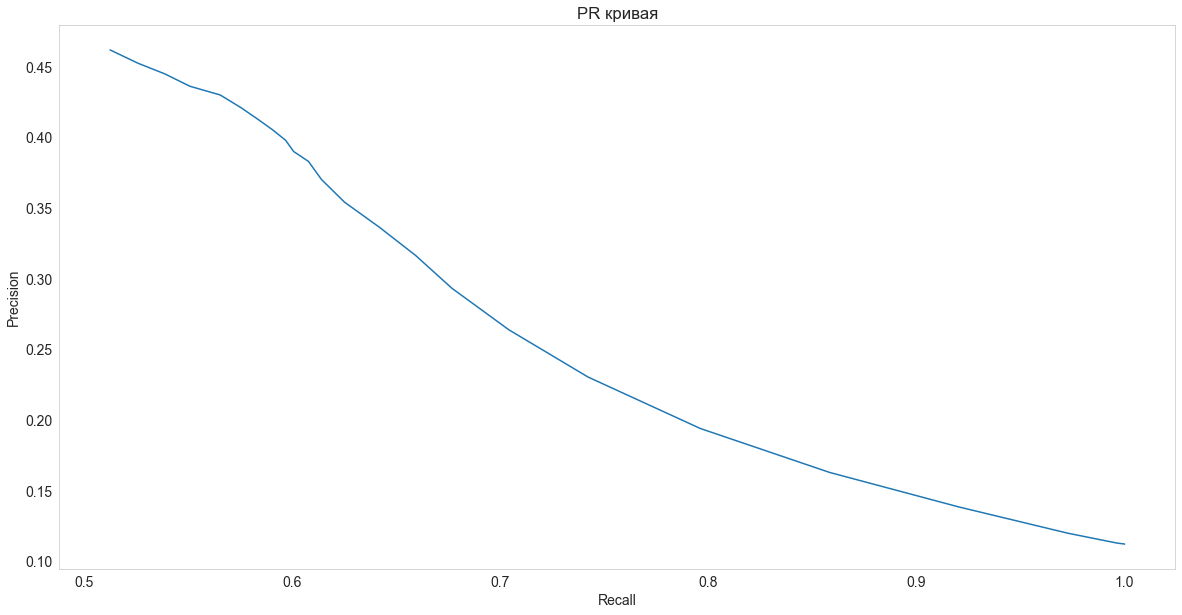

In [129]:
plt.figure(figsize=(20, 10))
plt.plot(good_thresholds_recall.values(), good_thresholds_precision.values())

plt.title('PR кривая')
plt.xlabel("Recall")
plt.ylabel('Precision')
plt.grid()

In [130]:
test = list(map(lambda x: x + 0.5, good_thresholds_precision.values()))

In [131]:
print('Площадь под кривой в зоне recall >= 0.5 равна:', auc(list(good_thresholds_recall.values()), list(good_thresholds_precision.values())))

Площадь под кривой в зоне recall >= 0.5 равна: 0.12297926751539978
